In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D ,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib

In [36]:
nb_train_samples = 40
nb_validation_samples = 4
epochs = 10
batch_size = 4

In [39]:
# Defining Image Path

train_path = 'data/rice_leaf/train'           # Test images
valid_path = 'data/rice_leaf/validation'      # Validation images - used for validation while training
test_path = 'data/rice_leaf/test'             # Test data used to plot confusion matrix after training
                                    # Confusion matrix is a simple plot to check accuracy of model.
                                    # Test accuracy and validation accuracy is plotted here
                                    # With this we can determine overwriting

In [40]:

train_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
                                    rotation_range=90, 
                                    brightness_range=[0.1, 0.7],
                                    width_shift_range=0.5, 
                                    height_shift_range=0.5,
                                    horizontal_flip=True, 
                                    vertical_flip=True,
                                    shear_range=0.2, 
                                    zoom_range=0.2, 
                               ).flow_from_directory(directory=train_path, target_size=(224,224), classes=['Bacterial leaf blight', 'Brown spot', 'Leaf smut'],batch_size=batch_size)
valid_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
    .flow_from_directory(directory=valid_path, target_size=(224,224,), classes=['Bacterial leaf blight', 'Brown spot', 'Leaf smut'],batch_size=4)
# test_batch=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
#     .flow_from_directory(directory=test_path, target_size=(224,224,), classes=['Bacterial leaf blight', 'Brown spot', 'Leaf smut'],batch_size=batch_size,shuffle=False)

Found 120 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


In [41]:
# Calling next batch, here batch size is 20, we plot this batch to look through pre processed images.

imgs, labels = next(train_batch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

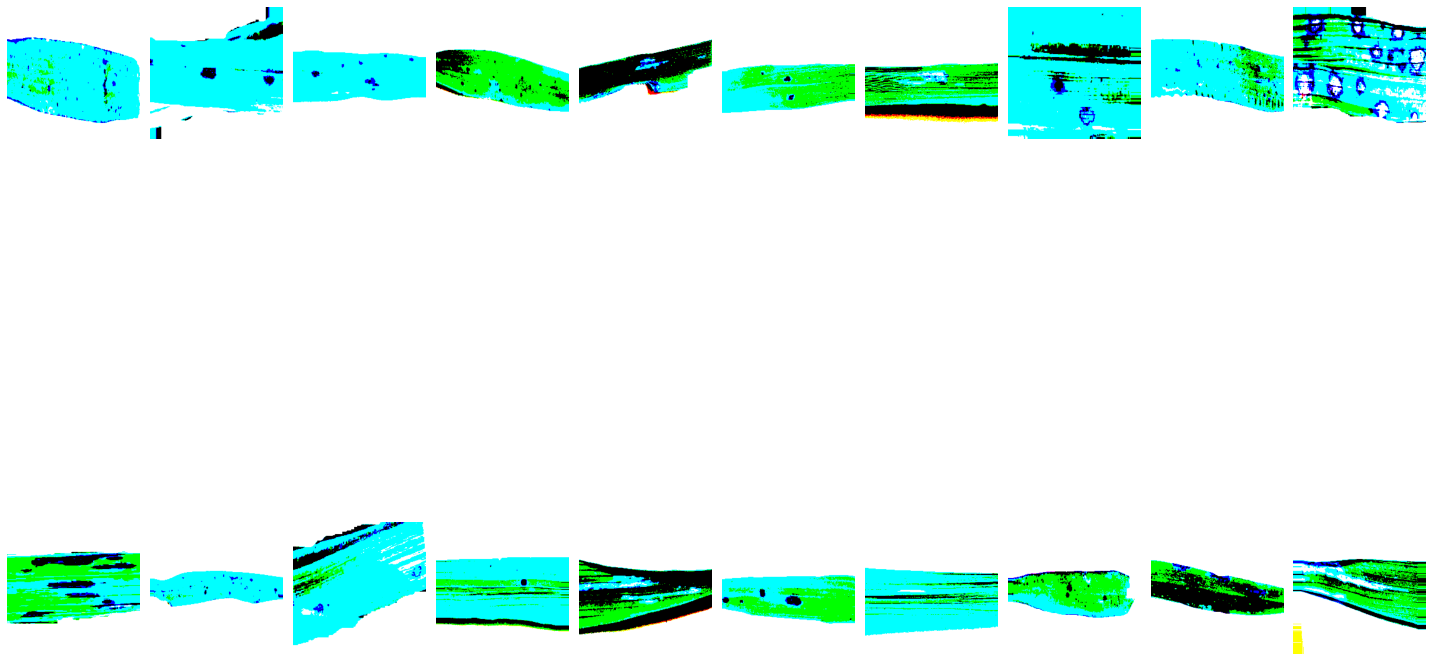

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [14]:
# A TensorFlow function, we copied directly from the tensorflow website
# This function will plot images in the form of a grid of 2 row with 10 columns each row


def plotImages(image_arr):
    fig, axes = plt.subplots(2, 10, figsize=(20,20))       # row, column and figure size
    axes = axes.flatten()
    for img, ax in zip(image_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)    # PLOT IMAGES.
print(labels)       # PRINT LABELS

In [42]:

# Creating a sequential neural network (Called a 'model' or 'Neural net' also)


model = Sequential([
    Conv2D(32, kernel_size=(3,3), input_shape=(224,224,3), padding='same', activation='relu'),   # refer:https://www.geeksforgeeks.org/keras-conv2d-class/
                                                                                    # images will have zero padding, Input shape is important because it is the first layer.
    MaxPooling2D(pool_size=(2,2)),                                                  # Down sampling. refer:https://keras.io/api/layers/pooling_layers/max_pooling2d/

    Conv2D(32,kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),                           # Convert 2D array to 1D array
    Dense(units=64, activation='relu'),  # Dense deeply connected layer. Refer:https://www.tutorialspoint.com/keras/keras_dense_layer.htm
    Dropout(0.5),                        # Dropout layer is added to reduce or prevent over-fitting. Refer:https://keras.io/api/layers/regularization_layers/dropout/
    Dense(units=3, activation='softmax') # Final layer has 2 units since we have two classifiers. 'softmax' will give probability corresponding to both classes.
])

# Printing out the built model
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 50176)            

In [43]:
# Compile neural network model
# Adem optimizer is better than rmsprop by some of the articles
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# We can use one dense layer with sigmoid Activation and loss equals 'binary cross entropy',
# but it is only used for binary classification, Also Sigmoid does not give probability for each class

In [44]:
# model.fit will perform training. (it returns history)
# 'steps per epoch' and 'validation steps' are important params
model.fit(
            x=train_batch,
            steps_per_epoch= nb_train_samples // batch_size,
            validation_data=valid_batch,
            validation_steps= nb_validation_samples // batch_size,
            epochs=epochs,
            verbose=1)

Epoch 1/10
10/10 [==============================] - 4s 431ms/step - loss: 43.6377 - acc: 0.3000 - val_loss: 27.7838 - val_acc: 0.5000
Epoch 2/10
10/10 [==============================] - 3s 282ms/step - loss: 29.5130 - acc: 0.4000 - val_loss: 9.7291 - val_acc: 0.2500
Epoch 3/10
10/10 [==============================] - 3s 272ms/step - loss: 12.3639 - acc: 0.5500 - val_loss: 4.2412 - val_acc: 0.2500
Epoch 4/10
10/10 [==============================] - 3s 302ms/step - loss: 7.0596 - acc: 0.3250 - val_loss: 1.4067 - val_acc: 0.5000
Epoch 5/10
10/10 [==============================] - 3s 299ms/step - loss: 1.7778 - acc: 0.4500 - val_loss: 1.0987 - val_acc: 0.2500
Epoch 6/10
10/10 [==============================] - 3s 273ms/step - loss: 1.1268 - acc: 0.2750 - val_loss: 1.0987 - val_acc: 0.2500
Epoch 7/10
10/10 [==============================] - 3s 279ms/step - loss: 1.0581 - acc: 0.4250 - val_loss: 1.0986 - val_acc: 0.2500
Epoch 8/10
10/10 [==============================] - 3s 275ms/step - loss

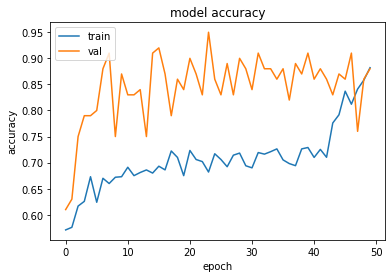

In [23]:
# MODEL ACCURACY
# we are plotting training accuracy and validation accuracy . To determine over-fitting

plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'],loc='upper left')
plt.show()

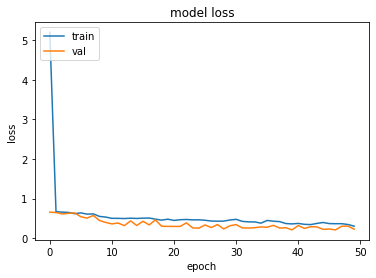

In [26]:
# MODEL LOSS
# we are plotting training loss and validation loss

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'],loc='upper left')
plt.show()

In [28]:
# Saving the model with its full structure, This can be loaded with 'keras.models.load_model("model_name.h5")'

model.save('model_jypter.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

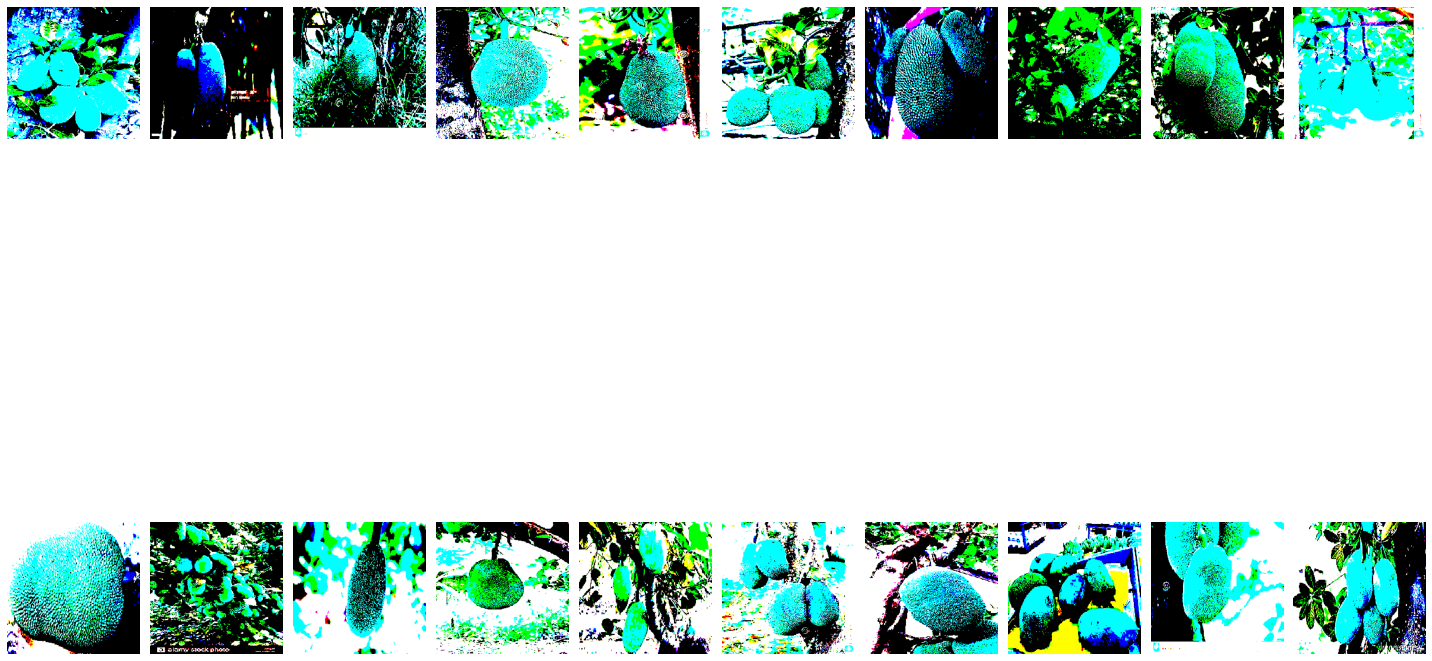

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [29]:
# import a test batch for making confusion matrix

test_imgs, test_labels = next(test_batch)
plotImages(test_imgs)
print(test_labels)

In [30]:
# Print labels (jackfruit, mango)= (0 , 1) ..of each images in test batch

test_batch.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [31]:
# Predict Test batch
# This test batch is already pre processed in the beginning

predictions = model.predict(x=test_batch, verbose=0)

In [32]:
# Non rounded prediction

print(predictions)

[[6.68376148e-01 3.31623852e-01]
 [3.74311030e-01 6.25688970e-01]
 [9.70902264e-01 2.90977079e-02]
 [9.95471001e-01 4.52899747e-03]
 [9.98502374e-01 1.49763282e-03]
 [9.67405796e-01 3.25941630e-02]
 [9.90682364e-01 9.31765605e-03]
 [9.65142429e-01 3.48575190e-02]
 [9.74076331e-01 2.59236693e-02]
 [9.78389502e-01 2.16104724e-02]
 [9.88797724e-01 1.12022702e-02]
 [9.74655449e-01 2.53445599e-02]
 [9.95861471e-01 4.13853256e-03]
 [9.82802451e-01 1.71975214e-02]
 [9.29243386e-01 7.07566068e-02]
 [9.66016591e-01 3.39833573e-02]
 [9.94087934e-01 5.91208879e-03]
 [6.08339548e-01 3.91660482e-01]
 [8.48749638e-01 1.51250362e-01]
 [9.70173478e-01 2.98265014e-02]
 [9.96734142e-01 3.26587982e-03]
 [9.87170756e-01 1.28291817e-02]
 [5.09761095e-01 4.90238905e-01]
 [9.33938742e-01 6.60611913e-02]
 [9.66109395e-01 3.38906571e-02]
 [9.87730563e-01 1.22694205e-02]
 [7.35278249e-01 2.64721751e-01]
 [9.69718277e-01 3.02817822e-02]
 [9.56562579e-01 4.34374250e-02]
 [9.07175243e-01 9.28247720e-02]
 [9.695377

In [33]:
# Rounded prediction ie: 0 or 1

np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [34]:
# Building confusion matrix

cm = confusion_matrix(y_true=test_batch.classes, y_pred=np.argmax(predictions, axis=-1))

In [40]:
#  function for Plotting confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [37]:
# Check labels

test_batch.class_indices

{'jackfruit': 0, 'mango': 1}

Confusion matrix, without normalization
[[48  2]
 [17 33]]


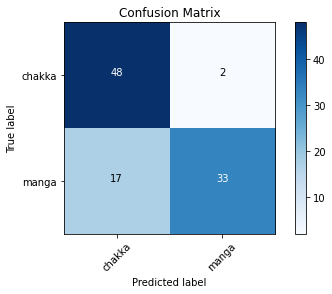

In [42]:
# PLOTTING THE CONFUSION MATRIX
cm_plot_labels = ['chakka', 'manga']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [49]:
#================ PREDICTION PART ===================#
# Load image as pixel data

from keras.preprocessing.image import load_img
# load image from file
image = load_img('data/test/jackfruit/978.jpg', target_size=(224, 224))

In [50]:
# Convert to a numpy array

from keras.preprocessing.image import img_to_array
image = img_to_array(image)

# Reshape image before preprocessing,   image reshaped from(224, 224, 3) to (1, 224, 224, 3)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

In [51]:
# Prepare Image in the required form of vgg16, we trained our model with image preprocessing of vgg16.
# Our model is not vgg16, We just used the image pre processing function from vgg 16 (subtract mean RGB)

from keras.applications.vgg16 import preprocess_input
image = preprocess_input(image)

In [58]:
# Import the saved model
model_1 = keras.models.load_model('model_jypter.h5')
rslt = model_1.predict(image)

In [59]:
# Print Prediction Result

print(rslt)

[[0.9565627  0.04343735]]


In [62]:
# rounded result
round_rslt = np.round(rslt)
print(round_rslt)

[[1. 0.]]


In [67]:
# Final output
if str(round_rslt[0][0])[0]=='1':  # checking the value of jackfruit label.
    prediction = 'Chakka'
else:
    prediction = 'Manga'
print(prediction)

Chakka
